# Mental Illness Classification

This projects, use model for classification such as:
- Voting Classifier:
    - CatBoost
    - XGBoost
    - LightGBM

### Import Libraries

In [82]:
# Data Science and Machine Learning Imports
import re
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import string

# Data Processing
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Appendix
import lime
import warnings
warnings.filterwarnings('ignore')

### Import datasets

In [83]:
df = pd.read_csv('../data/data.csv')

df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


Now we can try to get some information from the dataframe using:
```py
df.info()
```

We can understand some information such as:
- How many rows we have
- Null value / NaN values
- Data types for some rows

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


**Conclusions**:
- As you can see, there're Null values in this table since 53043 is the total rows we have and there are only 52681 Non-null values on the statements columns.
- There are also unwanted columns such as "Unnamed" that are having no use for the data learning.

Drop those Null columns and "Unnamed" Row

In [85]:
df.drop('Unnamed: 0',axis=1,inplace =True)
df.dropna(inplace=True)
df = df[df['statement'] != '']
df.reset_index(drop=True)

df.isnull().sum()

statement    0
status       0
dtype: int64

### Data Preprocessing

Data Distributions Plots

We now try to see how does the distributions work on our current dataset.

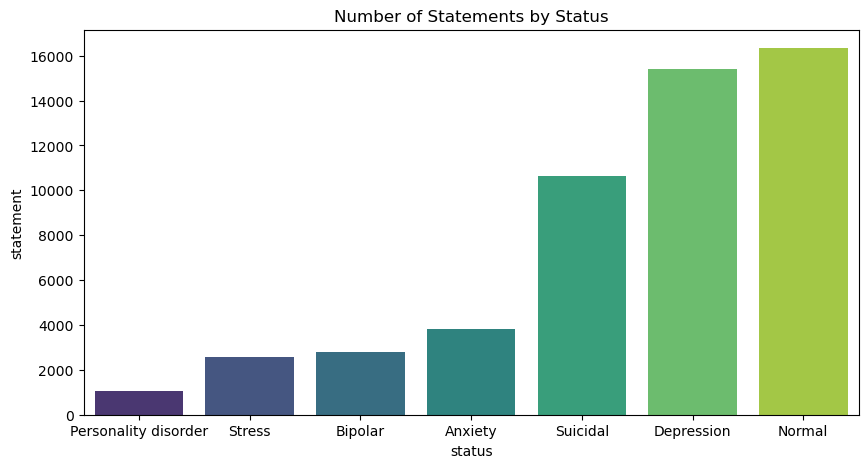

In [86]:
df.replace("", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
data = df.groupby('status')['statement'].count().sort_values().reset_index()

plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement', palette='viridis')
plt.title('Number of Statements by Status')
plt.show()

Normal has the most votes! Yet this data distributions appears unbalanced!

Now, Let's describe the data to see what statements appear the most (we also check for duplicates statements)

In [87]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


From our table here, we can see that normal people asks "what do you mean?" occurs around 22 times, yet it will be irrelevant for us to use that value. But still, duplicates doesn't mean bad for our data.

Using wordclouds to see how importants each word is:

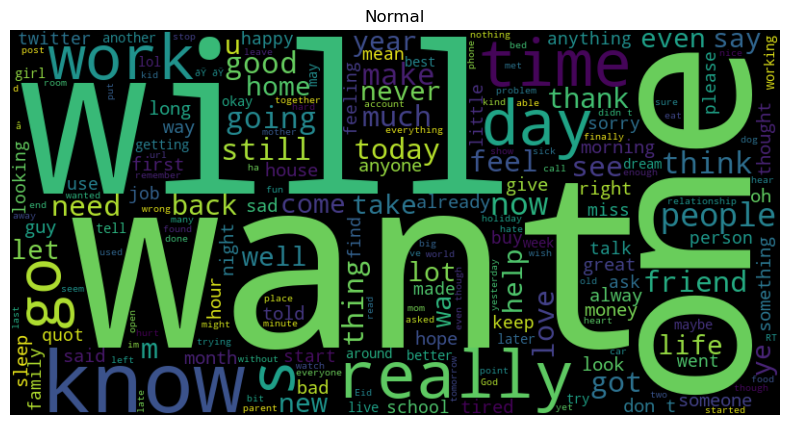

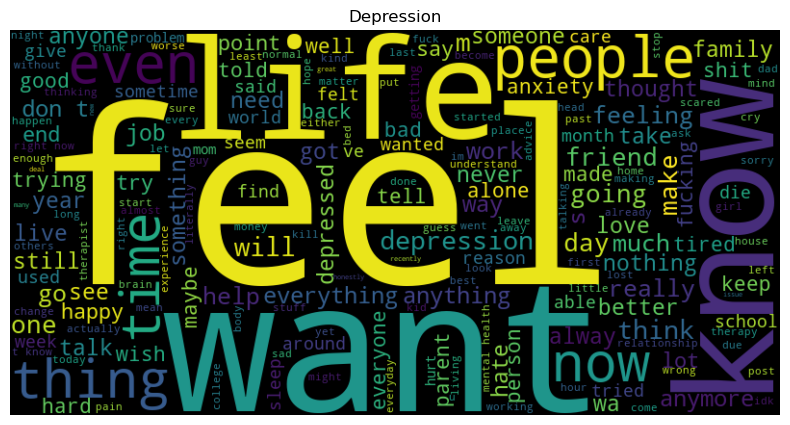

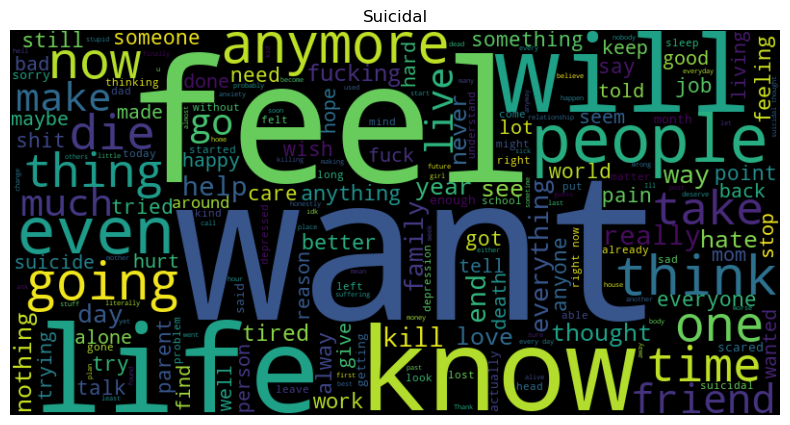

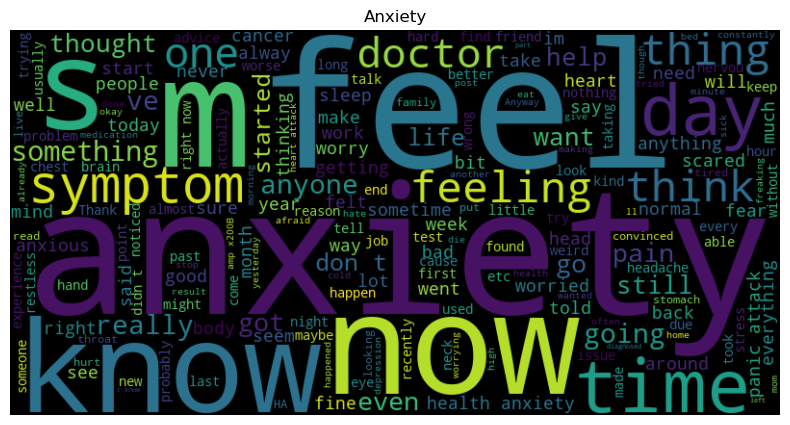

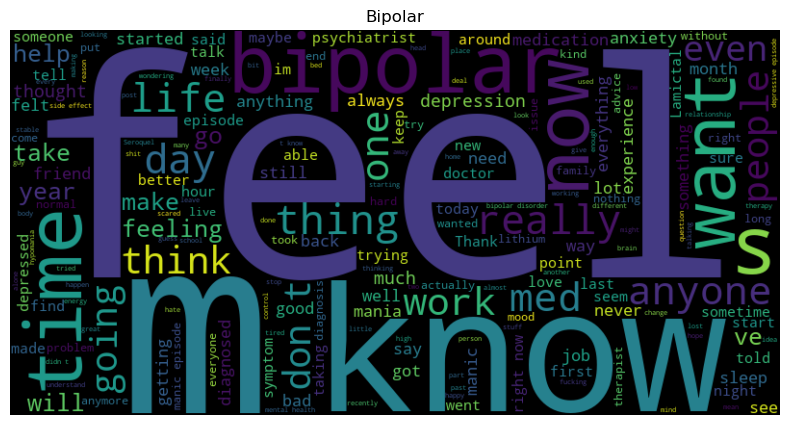

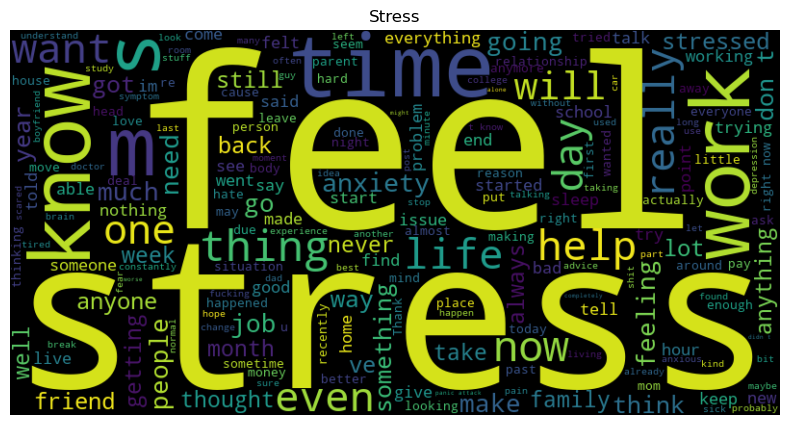

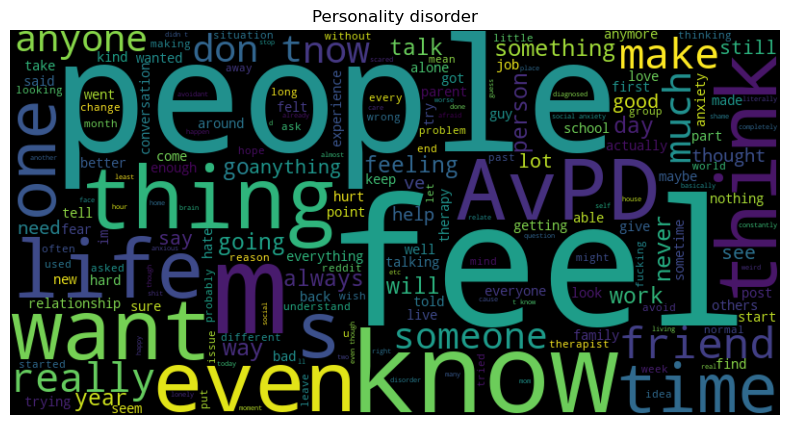

In [88]:
categories = df['status'].value_counts().index

for cat in categories:
    statements = " ".join(df[df['status']==cat]['statement'])

    wordcloud = WordCloud(width=800, height=400).generate(statements)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(cat)
    plt.axis('off')
    plt.show()

In [89]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['statement'] = df['statement'].apply(lambda x: preprocess_text(x))

### Label Encoding

In [90]:
label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

df['status'] = df['status'].map(label_ordered)

label_ordered

{'Normal': 0,
 'Depression': 1,
 'Suicidal': 2,
 'Anxiety': 3,
 'Bipolar': 4,
 'Stress': 5,
 'Personality disorder': 6}

In [91]:
df.head()

,statement,status
0,oh my gosh,3
1,trouble sleeping confused mind restless heart ...,3
2,all wrong back off dear forward doubt stay in ...,3
3,ive shifted my focus to something else but im ...,3
4,im restless and restless its been a month now ...,3


### Data Splitting

In [92]:
X = df['statement']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF Vectorizer

In [93]:
X_train_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', lowercase=True)
X_train_vectorized = X_train_vectorizer.fit_transform(X_train)
X_test_vectorized = X_train_vectorizer.transform(X_test)

X_train_vectorized.shape, X_test_vectorized.shape

((42144, 5000), (10537, 5000))

### Data Sampling (Balancing Data Distributions)

Data distributions before SMOTE

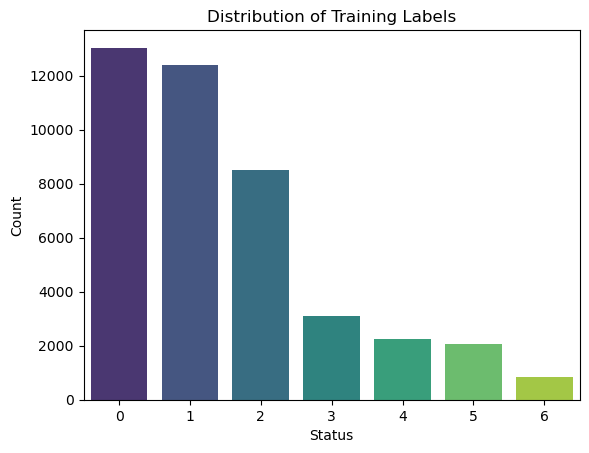

In [94]:
sns.barplot(y_train.value_counts(), palette='viridis')
plt.title('Distribution of Training Labels')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [95]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)

resampled_tuple = smote.fit_resample(X_train_vectorized, y_train)

X_train_resampled = resampled_tuple[0]
y_train_resampled = resampled_tuple[1]

Data distributions after SMOTE

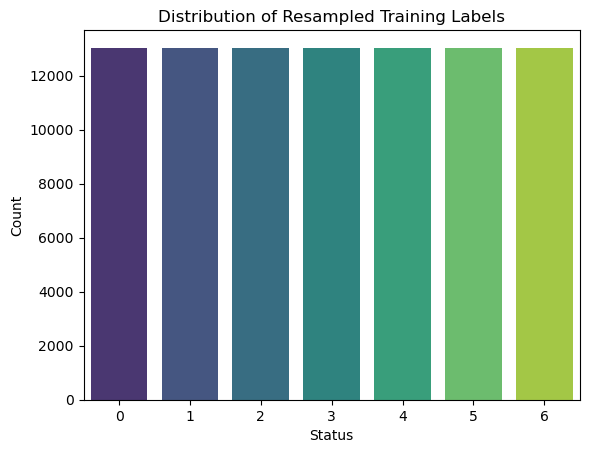

In [96]:
vc = y_train_resampled.value_counts().sort_index()
sns.barplot(x=vc.index, y=vc.values, palette='viridis')
plt.title('Distribution of Resampled Training Labels')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

### Model Training

##### CatBoost

In [ ]:
catboost_params = {
    "random_seed": 17,
    "eval_metric": "TotalF1", # ini sama aja kek F1:macro/weighted average F1
    "random_strength": 3,
    "od_type": "Iter",
    "verbose": 100,
    "early_stopping_rounds": 100,
    "iterations": 500,
    "learning_rate": 0.01,
}

In [113]:
catboost = CatBoostClassifier(**catboost_params)

catboost.fit(X_train_resampled, y_train_resampled)

Learning rate set to 0.099608
0:	learn: 0.4379971	total: 7.91s	remaining: 2h 11m 41s
100:	learn: 0.7167813	total: 4m 38s	remaining: 41m 22s
200:	learn: 0.7625223	total: 8m 47s	remaining: 34m 55s
300:	learn: 0.7847389	total: 12m 55s	remaining: 30m
400:	learn: 0.8002855	total: 16m 44s	remaining: 25m
500:	learn: 0.8107834	total: 20m 28s	remaining: 20m 23s
600:	learn: 0.8181366	total: 24m 9s	remaining: 16m 3s
700:	learn: 0.8242364	total: 27m 45s	remaining: 11m 51s
800:	learn: 0.8297131	total: 31m 24s	remaining: 7m 48s
900:	learn: 0.8338828	total: 34m 54s	remaining: 3m 50s
999:	learn: 0.8381705	total: 38m 21s	remaining: 0us


CatBoost Accuracy: 0.7562
                      precision    recall  f1-score   support

              Normal       0.85      0.93      0.89      3308
          Depression       0.76      0.64      0.70      3016
            Suicidal       0.67      0.70      0.68      2158
             Anxiety       0.76      0.76      0.76       755
             Bipolar       0.83      0.74      0.78       527
              Stress       0.51      0.63      0.56       536
Personality disorder       0.60      0.64      0.62       237

            accuracy                           0.76     10537
           macro avg       0.71      0.72      0.71     10537
        weighted avg       0.76      0.76      0.75     10537



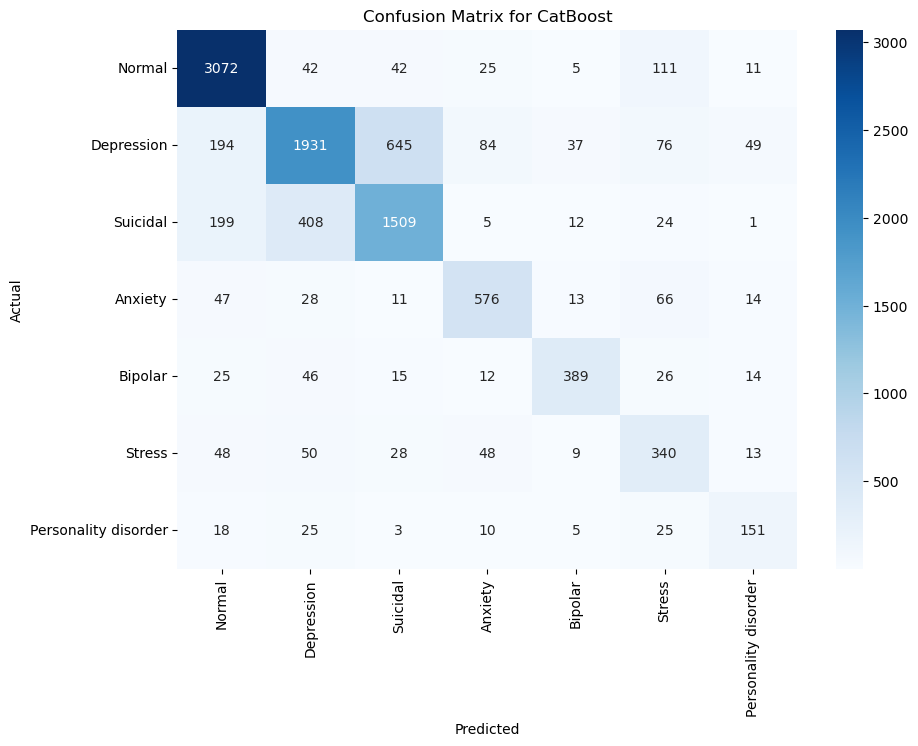

In [114]:
catboost_accuracy = accuracy_score(y_test, catboost.predict(X_test_vectorized))
print(f"CatBoost Accuracy: {catboost_accuracy:.4f}")

catboost_pred = catboost.predict(X_test_vectorized)
print(classification_report(y_test, catboost_pred, target_names=label_ordered.keys()))

cm = confusion_matrix(y_test, catboost_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_ordered.keys(), yticklabels=label_ordered.keys())
plt.title('Confusion Matrix for CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)
random_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Random Forest Accuracy: 0.7512
                      precision    recall  f1-score   support

              Normal       0.86      0.93      0.89      3308
          Depression       0.70      0.69      0.69      3016
            Suicidal       0.65      0.66      0.65      2158
             Anxiety       0.76      0.77      0.76       755
             Bipolar       0.84      0.74      0.79       527
              Stress       0.61      0.50      0.55       536
Personality disorder       0.91      0.53      0.67       237

            accuracy                           0.75     10537
           macro avg       0.76      0.69      0.72     10537
        weighted avg       0.75      0.75      0.75     10537



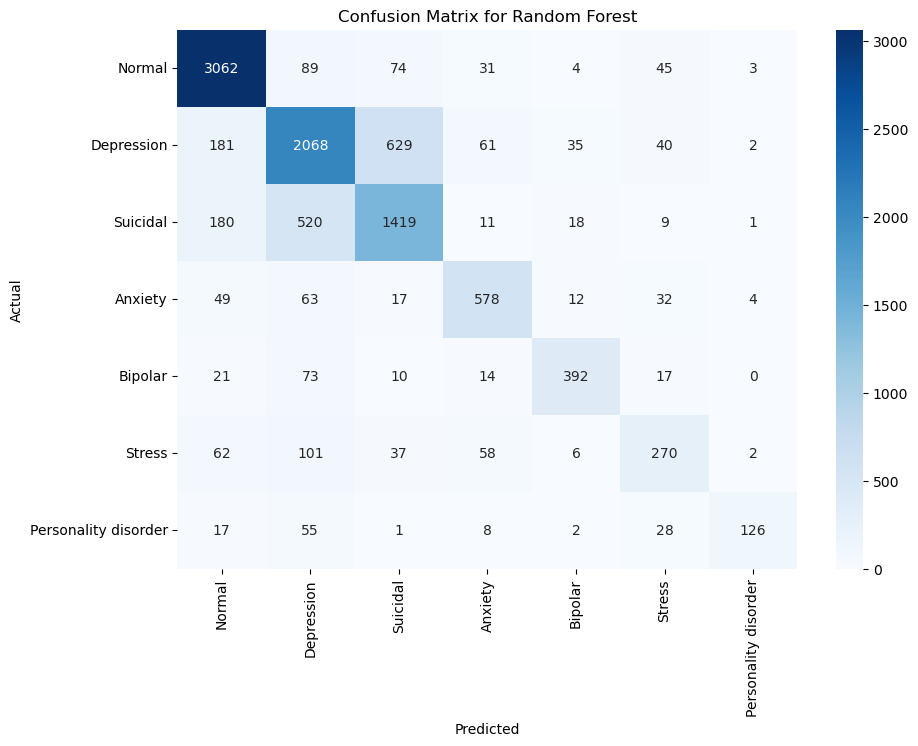

In [111]:
random_forest_accuracy = accuracy_score(y_test, random_forest.predict(X_test_vectorized))
print(f"Random Forest Accuracy: {random_forest_accuracy:.4f}")

rf_pred = random_forest.predict(X_test_vectorized)
print(classification_report(y_test, rf_pred, target_names=label_ordered.keys()))

cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_ordered.keys(), yticklabels=label_ordered.keys())
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Voting Classifier

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost),
        ('random_forest', random_forest)
    ],
    voting='soft',
    cv=3,
    weights=[1, 1],
)

voting_clf.fit(X_train_resampled, y_train_resampled)

In [ ]:
voting_accuracy = accuracy_score(y_test, voting_clf.predict(X_test_vectorized))
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

voting_pred = voting_clf.predict(X_test_vectorized)
print(classification_report(y_test, voting_pred, target_names=label_ordered.keys()))

cm_voting = confusion_matrix(y_test, voting_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues', xticklabels=label_ordered.keys(), yticklabels=label_ordered.keys())
plt.title('Confusion Matrix for Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Saving (.pkl)

In [ ]:
with open("../models/catboost_classifier.pkl", "wb") as f:
    pickle.dump(catboost, f)

with open("../models/random_forest_classifier.pkl", "wb") as f:
    pickle.dump(random_forest, f)

with open("../models/voting_classifier.pkl", "wb") as f:
    pickle.dump(voting_clf, f)

### LIME